# Embedding-based Search for Scientific Abstracts

#### Alden Dima  
alden.dima@nist.gov  
Information Systems Group  
Information Technology Laboratory  
National Institute of Standards and Technology

#### Terms of Use

This software was developed at the [National Institute of Standards and Technology (NIST)](https://www.nist.gov) by employees of the Federal Government in the course of their official duties.  Pursuant to Title 17 Section 105 of the United States Code this software is not subject to copyright protection and is in the public domain.  It is an experimental system.  NIST assumes no responsibility whatsoever for its use by other parties, and makes no guarantees, expressed or implied, about its quality, reliability, or any other characteristic.  We would appreciate acknowledgement if the software is used.

This software can be redistributed and/or modified freely provided that any derivative works bear some notice that they are derived from it, and any modified versions bear some notice that they have been modified.

#### Summary
This Jupyter notebook contains a prototype embedding-based text search method developed as a part of NIST's participation in the IARPA TrojAI Project to help accelerate the manual summarization of TrojAI-related literature being curated at the [TrojAI Literature Review GitHub repository](https://github.com/usnistgov/trojai-literature). 

Our method uses an [flair](https://github.com/flairNLP/flair) embeddings and a [gensim](https://radimrehurek.com/gensim/) similarity index created from the computer science subset of [arXiv](https://arxiv.org/). We then produce a list of the top-ranked abstracts as the results of the query.

In [1]:
from flair.embeddings import Sentence
from flair.embeddings import FlairEmbeddings, DocumentPoolEmbeddings
import torch
import gensim.matutils
from gensim.similarities import Similarity
from gensim.test.utils import get_tmpfile
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

In [2]:
plt.rcParams['figure.figsize'] = (15,20)

#### Stacking previously created forwards and backwards flair embeddings for arXiv CS titles and abstracts.

In [3]:
cs_forward = FlairEmbeddings('language_model/arXiv-cs-lc-forward.pt')
cs_backward = FlairEmbeddings('language_model/arXiv-cs-lc-backward.pt')

In [4]:
document_embeddings = DocumentPoolEmbeddings(
                        [
                            cs_forward,
                            cs_backward
                        ],
                        pooling='mean',
                        fine_tune_mode='linear')

#### Abstract titles and text saved in Python pickle format from the embedding and index creation processes.

In [5]:
with open('title-abstracts.pkl', 'rb') as fsent:
    sents = pickle.load(fsent)

#### Loading previously created gensim similiarity index containing embedding of each documents title and abstracts.

In [6]:
idx = Similarity.load('title-abstracts.idx')

#### Some utility functions for creating queries

In [7]:
# Normalizing the spaces makes a big difference with character-based embeddings!
spat = re.compile("\s+")

def normspaces(s):
    return re.sub(spat, " ", s)

In [8]:
def embed_sentence(s):
    sent = Sentence(normspaces(s))
    document_embeddings.embed(sent)
    emb = sent.get_embedding().cpu().detach().numpy()
    return emb

In [9]:
def emb2sparse(emb):
    sparse = gensim.matutils.any2sparse(emb)
    return sparse

#### We are using a document's title and abstract as a query to create a ranked list of other similary documents.

In [10]:
qry = """
Neural Trojans. While neural networks demonstrate stronger capabilities in 
pattern recognition nowadays, they are also becoming larger and deeper. As a 
result, the effort needed to train a network also increases dramatically. In 
many cases, it is more practical to use a neural network intellectual property 
(IP) that an IP vendor has already trained. As we do not know about the training 
process, there can be security threats in the neural IP: the IP vendor 
(attacker) may embed hidden malicious functionality, i.e. neural Trojans, into 
the neural IP. We show that this is an effective attack and provide three 
mitigation techniques: input anomaly detection, re-training, and input 
preprocessing. All the techniques are proven effective. The input anomaly 
detection approach is able to detect 99.8% of Trojan triggers although with 
12.2% false positive. The re-training approach is able to prevent 94.1% of 
Trojan triggers from triggering the Trojan although it requires that the neural 
IP be reconfigurable. In the input preprocessing approach, 90.2% of Trojan 
triggers are rendered ineffective and no assumption about the neural IP is 
needed.
"""

In [11]:
num_selected = 50
qry = qry.strip().lower()
q = emb2sparse(embed_sentence(qry))
hits = sorted(enumerate(idx[q]), key=lambda x:x[1], reverse=True)
hits_selected = hits[0:num_selected]

#### Sanity check - we expect the maximum similarity to be close to one for documents that are already in the arXiv CS subset

In [12]:
max(idx[q])

0.9999991

#### Creating a word cloud to visualize the top results.

In [13]:
sents_selected = [sents[i] for i,v in hits_selected]
text_selected = " ".join(sents_selected)
wordcloud = WordCloud(height=750, 
                      width=1000, 
                      random_state=43,
                      background_color='white',
                      color_func=lambda *args, **kwargs: "black",
                      relative_scaling=1).generate(text_selected)

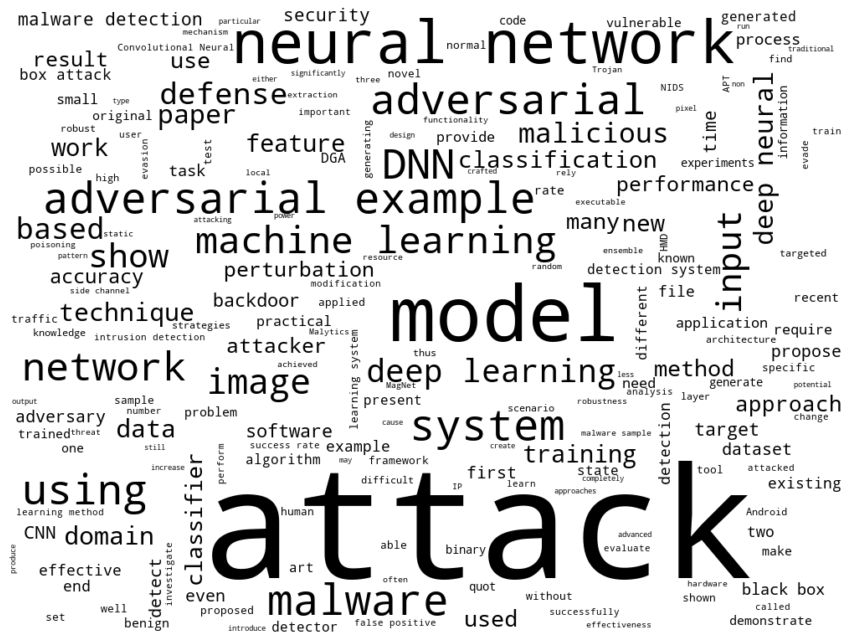

In [14]:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### The top ranked search results

In [15]:
c = 0
for i,v in hits_selected:
    c += 1
    print("{}\t{}\t{}\n".format(c, format(v.item(), ".2f"), sents[i]))

1	1.00	Neural Trojans. While neural networks demonstrate stronger capabilities in pattern recognition nowadays, they are also becoming larger and deeper. As a result, the effort needed to train a network also increases dramatically. In many cases, it is more practical to use a neural network intellectual property (IP) that an IP vendor has already trained. As we do not know about the training process, there can be security threats in the neural IP: the IP vendor (attacker) may embed hidden malicious functionality, i.e. neural Trojans, into the neural IP. We show that this is an effective attack and provide three mitigation techniques: input anomaly detection, re-training, and input preprocessing. All the techniques are proven effective. The input anomaly detection approach is able to detect 99.8% of Trojan triggers although with 12.2% false positive. The re-training approach is able to prevent 94.1% of Trojan triggers from triggering the Trojan although it requires that the neural IP b